# Facial Pose Processing Pipeline - Visualization Notebook

This notebook provides a step-by-step walkthrough of the facial pose processing pipeline with visualizations at each stage.


## Important
Run the 'process_pose_data.py' first (after downloading the raw pose data) 

## Overview

The pipeline consists of 8 steps:
1. **Load Raw Data** - Read OpenPose CSV files
2. **Filter Keypoints** - Keep only relevant facial landmarks
3. **Mask Low Confidence** - Remove unreliable detections
4. **Interpolate & Filter** - Clean temporal signals
5. **Normalize Coordinates** - Convert to screen-relative units
6. **Build Templates** - Create alignment references
7. **Extract Features** - Compute behavioral metrics
8. **Linear Metrics** - Calculate motion statistics

Each step includes:
- **Status check** - See if outputs already exist
- **Processing** - Run the step if needed
- **Visualization** - Display results to understand the transformation

## Setup and Imports

First, we'll import all necessary libraries and configure the environment.

In [2]:
# Standard imports
import os
import sys
import json
import warnings
from pathlib import Path
from typing import Dict, List, Tuple, Optional

# Data processing
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Circle
import plotly.graph_objects as go
import plotly.express as px
from IPython.display import display, HTML, Markdown

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

# Configure display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
warnings.filterwarnings('ignore')

# Add project path to system path
ROOT = Path.cwd()
if str(ROOT) not in sys.path:
    sys.path.insert(0, str(ROOT))

print(f"Working directory: {ROOT}")

Working directory: /Users/mikerichardson/Projects/MATB-Workload-Classification-Facial-Pose-Data/pose


## Import Pipeline Utilities

Import our custom processing modules and configuration.

In [3]:
# Import configuration and flags
from utils.config import CFG, SCIPY_AVAILABLE
from utils.config import (
    RUN_FILTER, RUN_MASK, RUN_INTERP_FILTER, RUN_NORM, RUN_TEMPLATES,
    RUN_FEATURES_PROCRUSTES_GLOBAL, RUN_FEATURES_PROCRUSTES_PARTICIPANT,
    RUN_FEATURES_ORIGINAL, RUN_LINEAR,
    SAVE_REDUCED, SAVE_MASKED, SAVE_INTERP_FILTERED, SAVE_NORM,
    OVERWRITE, OVERWRITE_TEMPLATES, SCALE_BY_INTEROCULAR
)

# Import utilities
from utils.io_utils import (
    ensure_dirs, load_raw_files, get_output_filename, 
    load_participant_info_file, write_per_frame_metrics
)
from utils.preprocessing_utils import (
    parse_participant_trial, detect_conf_prefix_case_insensitive,
    relevant_indices, filter_df_to_relevant, confidence_mask,
    load_participant_info, create_condition_mapping, get_condition_for_file
)
from utils.signal_utils import interpolate_run_limited, butterworth_segment_filter
from utils.normalize_utils import normalize_to_screen, interocular_series
from utils.features_utils import (
    procrustes_features_for_file, original_features_for_file,
    compute_linear_from_perframe_dir
)
from utils.window_utils import window_features

print("All utilities imported successfully!")

# Display configuration
print("\nCurrent Configuration:")
print(f"  RAW_DIR: {CFG.RAW_DIR}")
print(f"  OUT_BASE: {CFG.OUT_BASE}")
print(f"  FPS: {CFG.FPS} Hz")
print(f"  CONF_THRESH: {CFG.CONF_THRESH}")
print(f"  OVERWRITE: {OVERWRITE}")

All utilities imported successfully!

Current Configuration:
  RAW_DIR: /Users/mikerichardson/Projects/MATB-Workload-Classification-Facial-Pose-Data/pose/data/raw_data
  OUT_BASE: /Users/mikerichardson/Projects/MATB-Workload-Classification-Facial-Pose-Data/pose/data/processed
  FPS: 60 Hz
  CONF_THRESH: 0.3
  OVERWRITE: True


## Helper Functions for Visualization

Custom functions to create informative plots at each processing step.

In [4]:
def plot_landmark_scatter(df, title="Facial Landmarks", sample_frame=0):
    """Plot facial landmarks as a scatter plot."""
    fig, ax = plt.subplots(figsize=(6, 6))
    
    # Extract x and y coordinates for the sample frame
    x_cols = [c for c in df.columns if c.lower().startswith('x')]
    y_cols = [c for c in df.columns if c.lower().startswith('y')]
    
    if len(df) > sample_frame:
        x_vals = df[x_cols].iloc[sample_frame].values
        y_vals = df[y_cols].iloc[sample_frame].values
        
        # Invert y-axis for image coordinates
        ax.scatter(x_vals, y_vals, s=50, c='blue', alpha=0.6)
        
        # Mark key landmarks
        key_indices = [36, 45, 30, 48, 54]  # Eyes, nose, mouth (0-indexed)
        for idx in key_indices:
            if idx < len(x_vals):
                ax.scatter(x_vals[idx], y_vals[idx], s=200, marker='o', facecolors='none', edgecolors='red', linewidths=1.5)
    
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.invert_yaxis()  # Invert for image coordinates
    ax.set_aspect('equal')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


def plot_confidence_histogram(df, conf_prefix='prob'):
    """Plot histogram of confidence values."""
    conf_cols = [c for c in df.columns if c.lower().startswith(conf_prefix.lower())]
    
    if conf_cols:
        fig, ax = plt.subplots(figsize=(6, 3))
        
        # Flatten all confidence values
        all_conf = df[conf_cols].values.flatten()
        all_conf = all_conf[~np.isnan(all_conf)]  # Remove NaNs
        
        ax.hist(all_conf, bins=50, alpha=0.7, color='green', edgecolor='black')
        ax.axvline(CFG.CONF_THRESH, color='red', linestyle='--', linewidth=2, 
                   label=f'Threshold ({CFG.CONF_THRESH})')
        
        ax.set_title('Confidence Distribution', fontsize=14, fontweight='bold')
        ax.set_xlabel('Confidence Score')
        ax.set_ylabel('Frequency')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Add statistics
        ax.text(0.02, 0.98, f'Mean: {np.mean(all_conf):.3f}\nStd: {np.std(all_conf):.3f}',
                transform=ax.transAxes, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        
        plt.tight_layout()
        plt.show()


def plot_time_series(df, landmark_idx=37, title="Landmark Time Series"):
    """Plot x and y coordinates over time for a specific landmark."""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 3), sharex=True)
    
    # Find columns for this landmark
    x_col = f'x{landmark_idx}'
    y_col = f'y{landmark_idx}'
    
    # Check case-insensitive
    x_col = next((c for c in df.columns if c.lower() == x_col.lower()), None)
    y_col = next((c for c in df.columns if c.lower() == y_col.lower()), None)
    
    if x_col and y_col:
        frames = np.arange(len(df))
        
        # Plot X coordinate
        ax1.plot(frames, df[x_col], linewidth=1, color='blue', alpha=0.7)
        ax1.set_ylabel('X Coordinate', fontsize=10)
        ax1.set_title(f'{title} - Landmark {landmark_idx}', fontsize=12, fontweight='bold')
        ax1.grid(True, alpha=0.3)
        
        # Highlight NaN regions
        nan_mask = pd.isna(df[x_col])
        if nan_mask.any():
            ax1.fill_between(frames, ax1.get_ylim()[0], ax1.get_ylim()[1], 
                            where=nan_mask, alpha=0.3, color='red', label='Missing data')
        
        # Plot Y coordinate
        ax2.plot(frames, df[y_col], linewidth=1, color='green', alpha=0.7)
        ax2.set_xlabel('Frame Number', fontsize=10)
        ax2.set_ylabel('Y Coordinate', fontsize=10)
        ax2.grid(True, alpha=0.3)
        
        # Highlight NaN regions
        if nan_mask.any():
            ax2.fill_between(frames, ax2.get_ylim()[0], ax2.get_ylim()[1],
                            where=nan_mask, alpha=0.3, color='red')
            ax1.legend(loc='upper right')
    
    plt.tight_layout()
    plt.show()


def check_files_exist(pattern, directory):
    """Check if files matching pattern exist in directory."""
    dir_path = Path(directory)
    if dir_path.exists():
        files = list(dir_path.glob(pattern))
        return len(files) > 0, files
    return False, []


def check_all_step_outputs():
    """Check completion status of all pipeline steps."""
    steps = {
        "Step 1 - Raw Data": (CFG.RAW_DIR, "*_pose.csv"),
        "Step 2 - Filtered": (Path(CFG.OUT_BASE) / "reduced", "*_reduced.csv"),
        "Step 3 - Masked": (Path(CFG.OUT_BASE) / "masked", "*_masked.csv"),
        "Step 4 - Interpolated": (Path(CFG.OUT_BASE) / "interp_filtered", "*_interp_filt.csv"),
        "Step 5 - Normalized": (Path(CFG.OUT_BASE) / "norm_screen", "*_norm.csv"),
        "Step 6 - Templates": (Path(CFG.OUT_BASE) / "templates", "*.csv"),
        "Step 7 - Features": (Path(CFG.OUT_BASE) / "features", "*.csv"),
        "Step 8 - Linear Metrics": (Path(CFG.OUT_BASE) / "linear_metrics", "*_linear.csv")
    }

    status_data = []
    for step_name, (directory, pattern) in steps.items():
        exists, files = check_files_exist(pattern, directory)
        status_data.append({
            'Step': step_name,
            'Status': 'Complete' if exists else '⏳ Pending',
            'Files': len(files),
            'Directory': str(directory)
        })

    return pd.DataFrame(status_data)


def get_pipeline_completion_percentage():
    """Calculate percentage of pipeline steps completed."""
    status_df = check_all_step_outputs()
    completed = (status_df['Status'] == 'Complete').sum()
    total = len(status_df)
    return (completed / total) * 100, completed, total


def display_status(step_name, exists, file_count=0):
    """Display status of a processing step."""
    if exists:
        status = f"<b>{step_name}</b>: Already processed ({file_count} files found)"
        color = "green"
    else:
        status = f"<b>{step_name}</b>: Needs processing"
        color = "orange"
    
    display(HTML(f'<div style="padding:10px;background-color:{color};opacity:0.2;border-radius:5px;">{status}</div>'))


print("Visualization functions ready!")

# Check overall pipeline status
completion_pct, completed_steps, total_steps = get_pipeline_completion_percentage()
print(f"\nPipeline Status: {completion_pct:.1f}% complete ({completed_steps}/{total_steps} steps)")

# Display detailed status
status_summary = check_all_step_outputs()
display('Pipeline Status Overview')
display(status_summary)

if completion_pct < 100:
    print("\nTo complete missing steps, run: python process_pose_data.py")
else:
    print("\nAll pipeline steps are complete!")

Visualization functions ready!

Pipeline Status: 100.0% complete (8/8 steps)


'Pipeline Status Overview'

,Step,Status,Files,Directory
0,Step 1 - Raw Data,Complete,143,/Users/mikerichardson/Projects/MATB-Workload-C...
1,Step 2 - Filtered,Complete,143,/Users/mikerichardson/Projects/MATB-Workload-C...
2,Step 3 - Masked,Complete,143,/Users/mikerichardson/Projects/MATB-Workload-C...
3,Step 4 - Interpolated,Complete,143,/Users/mikerichardson/Projects/MATB-Workload-C...
4,Step 5 - Normalized,Complete,143,/Users/mikerichardson/Projects/MATB-Workload-C...
5,Step 6 - Templates,Complete,49,/Users/mikerichardson/Projects/MATB-Workload-C...
6,Step 7 - Features,Complete,3,/Users/mikerichardson/Projects/MATB-Workload-C...
7,Step 8 - Linear Metrics,Complete,3,/Users/mikerichardson/Projects/MATB-Workload-C...



All pipeline steps are complete!


## Initialize Pipeline

Load participant information and prepare the processing environment.

In [5]:
# Ensure output directories exist
ensure_dirs()

# Load participant information
try:
    participant_info_path = load_participant_info_file()
    participant_info = load_participant_info(str(participant_info_path))
    condition_map = create_condition_mapping(participant_info)
    
    display('Participant Information Loaded')
    print(f"Loaded mapping for {len(condition_map)} participants")
    
    # Display sample of participant info
    display(HTML('<b>Sample Participant Mappings:</b>'))
    for pid in list(condition_map.keys())[:3]:
        print(f"  Participant {pid}: {condition_map[pid]}")
        
except FileNotFoundError as e:
    display(f'Error: {e}')
    print("Please ensure participant_info.csv exists in the RAW_DIR")

'Participant Information Loaded'

Loaded mapping for 50 participants


  Participant 3101: {1: 'L', 2: 'M', 3: 'H'}
  Participant 3102: {1: 'L', 2: 'M', 3: 'H'}
  Participant 3103: {1: 'L', 2: 'M', 3: 'H'}


## Step 1: Load Raw Data

Load OpenPose CSV files and examine the raw data structure.

'Step 1: Load Raw Data'

Found 143 pose CSV files

Files to process:
  1. 3101_01_pose.csv → Participant 3101, Trial 1, Condition L
  2. 3101_02_pose.csv → Participant 3101, Trial 2, Condition M
  3. 3101_03_pose.csv → Participant 3101, Trial 3, Condition H
  4. 3102_01_pose.csv → Participant 3102, Trial 1, Condition L
  5. 3102_02_pose.csv → Participant 3102, Trial 2, Condition M
  ... and 138 more files

Examining first file...
Shape: (30598, 210)
Columns: 210 (x, y, confidence for 70 landmarks)
Frames: 30598
Duration: 510.0 seconds at 60 fps


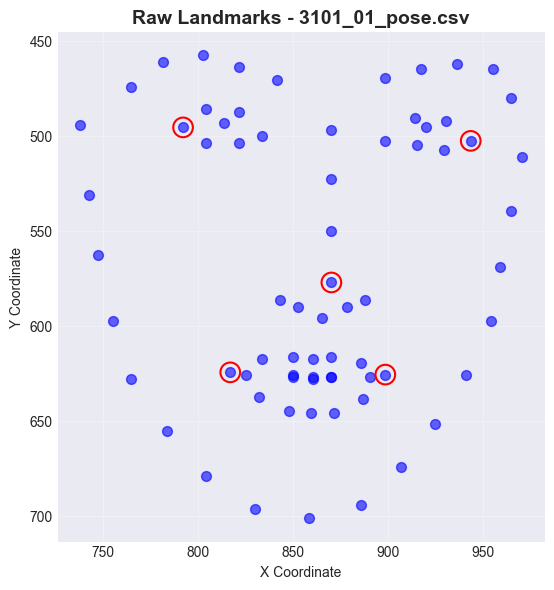

In [5]:
display('Step 1: Load Raw Data')

# Load file list
files = load_raw_files()
print(f"Found {len(files)} pose CSV files")

# Display file information
if files:
    print("\nFiles to process:")
    for i, fp in enumerate(files[:5], 1):
        pid, trial = parse_participant_trial(fp.name)
        cond = get_condition_for_file(fp.name, condition_map)
        print(f"  {i}. {fp.name} → Participant {pid}, Trial {trial}, Condition {cond}")
    
    if len(files) > 5:
        print(f"  ... and {len(files)-5} more files")
    
    # Load and examine first file
    print("\nExamining first file...")
    df_sample = pd.read_csv(files[0])
    
    print(f"Shape: {df_sample.shape}")
    print(f"Columns: {len(df_sample.columns)} (x, y, confidence for {len(df_sample.columns)//3} landmarks)")
    print(f"Frames: {len(df_sample)}")
    print(f"Duration: {len(df_sample)/CFG.FPS:.1f} seconds at {CFG.FPS} fps")
    
    # Visualize raw landmarks
    plot_landmark_scatter(df_sample, title=f"Raw Landmarks - {files[0].name}", sample_frame=100)
    
else:
    display('Error - No pose CSV files found!')

## Step 2: Filter to Relevant Keypoints

Keep only the landmarks needed for analysis, reducing data size significantly.

'Step 2: Filter to Relevant Keypoints'


Processing...
Confidence prefix detected: 'prob'
Keeping 23 landmarks: [28, 29, 30, 31, 32, 33, 34, 35, 36, 37]...

Data reduction:
  Original: 210 columns
  Filtered: 69 columns
  Reduction: 67.1%


Filtering all files:   0%|          | 0/143 [00:00<?, ?it/s]

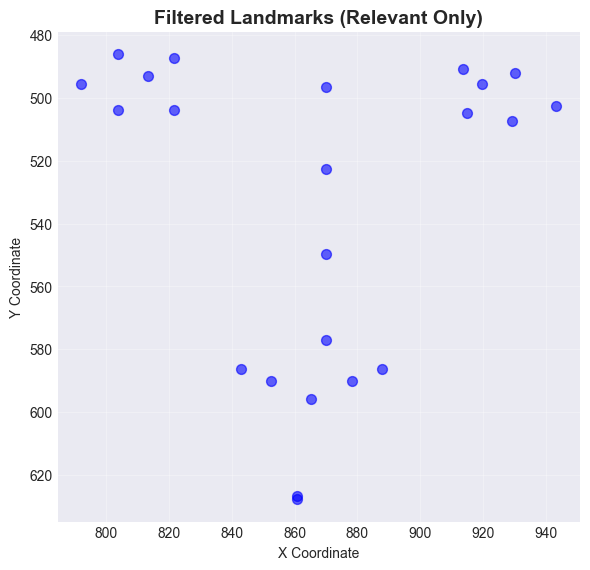

In [6]:
display('Step 2: Filter to Relevant Keypoints')

# Check if already processed
reduced_dir = Path(CFG.OUT_BASE) / "reduced"
exists, reduced_files = check_files_exist("*_reduced.csv", reduced_dir)
display_status("Filtered keypoints", exists, len(reduced_files))

if not exists or OVERWRITE:
    print("\nProcessing...")
    
    # Process first file as example
    df_raw = pd.read_csv(files[0])
    conf_prefix = detect_conf_prefix_case_insensitive(list(df_raw.columns))
    indices = relevant_indices()
    
    print(f"Confidence prefix detected: '{conf_prefix}'")
    print(f"Keeping {len(indices)} landmarks: {indices[:10]}...")
    
    # Filter to relevant landmarks
    df_reduced = filter_df_to_relevant(df_raw, conf_prefix, indices)
    
    print(f"\nData reduction:")
    print(f"  Original: {df_raw.shape[1]} columns")
    print(f"  Filtered: {df_reduced.shape[1]} columns")
    print(f"  Reduction: {(1 - df_reduced.shape[1]/df_raw.shape[1])*100:.1f}%")
    
    # Save if requested
    if SAVE_REDUCED:
        for fp in tqdm(files, desc="Filtering all files"):
            df = pd.read_csv(fp)
            cp = detect_conf_prefix_case_insensitive(list(df.columns))
            df_filt = filter_df_to_relevant(df, cp, indices)
            
            pid, _ = parse_participant_trial(fp.name)
            cond = get_condition_for_file(fp.name, condition_map)
            out_name = get_output_filename(fp.name, pid, cond, "_reduced")
            out_path = reduced_dir / out_name
            
            if OVERWRITE or not out_path.exists():
                df_filt.to_csv(out_path, index=False)
    
    # Visualize filtered landmarks
    plot_landmark_scatter(df_reduced, title="Filtered Landmarks (Relevant Only)", sample_frame=100)
    
else:
    print("Loading existing filtered data for visualization...")
    df_reduced = pd.read_csv(reduced_files[0])
    plot_landmark_scatter(df_reduced, title=f"Filtered Landmarks - {reduced_files[0].name}", sample_frame=100)

## Step 3: Mask Low-Confidence Landmarks

Set landmarks with low confidence to NaN to ensure robust analysis.

'Step 3: Mask Low-Confidence Landmarks'

Confidence distribution before masking:


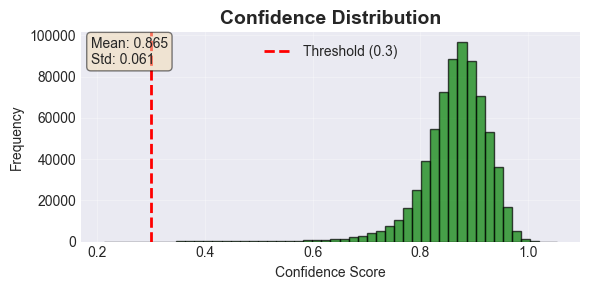


Processing...

Masking Statistics:
  Total coordinates: 1407508
  Masked coordinates: 54
  Percentage masked: 0.0%


Masking all files:   0%|          | 0/143 [00:00<?, ?it/s]


Effect of masking on landmark trajectory:


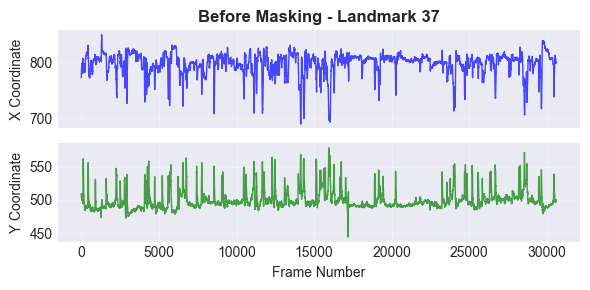

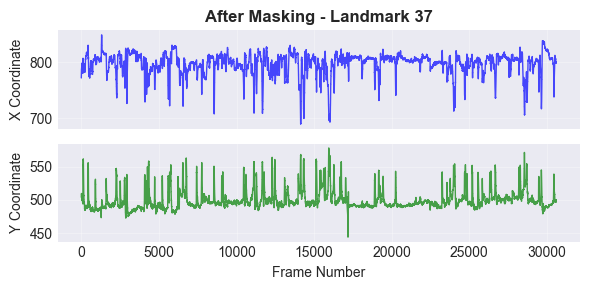

In [7]:
display('Step 3: Mask Low-Confidence Landmarks')

# Check if already processed
masked_dir = Path(CFG.OUT_BASE) / "masked"
exists, masked_files = check_files_exist("*_masked.csv", masked_dir)
display_status("Confidence masking", exists, len(masked_files))

# Get confidence prefix for visualization
if 'df_reduced' in locals():
    conf_prefix = detect_conf_prefix_case_insensitive(list(df_reduced.columns))
    
    # Show confidence distribution before masking
    print("Confidence distribution before masking:")
    plot_confidence_histogram(df_reduced, conf_prefix)

if not exists or OVERWRITE:
    print("\nProcessing...")
    
    # Apply confidence masking to example
    indices = relevant_indices()
    df_masked, stats = confidence_mask(df_reduced, conf_prefix, indices, CFG.CONF_THRESH)
    
    # Display statistics
    print("\nMasking Statistics:")
    overall = stats['overall']
    print(f"  Total coordinates: {overall['total_coord_values']}")
    print(f"  Masked coordinates: {overall['total_coords_masked']}")
    print(f"  Percentage masked: {overall['pct_coords_masked']:.1f}%")
    
    # Save if requested
    if SAVE_MASKED:
        for fp in tqdm(files, desc="Masking all files"):
            # Load reduced version if it exists
            pid, _ = parse_participant_trial(fp.name) 
            cond = get_condition_for_file(fp.name, condition_map)
            
            reduced_path = reduced_dir / get_output_filename(fp.name, pid, cond, "_reduced")
            if reduced_path.exists():
                df = pd.read_csv(reduced_path)
            else:
                df = pd.read_csv(fp)
                cp = detect_conf_prefix_case_insensitive(list(df.columns))
                df = filter_df_to_relevant(df, cp, indices)
            
            cp = detect_conf_prefix_case_insensitive(list(df.columns))
            df_m, _ = confidence_mask(df, cp, indices, CFG.CONF_THRESH)
            
            out_name = get_output_filename(fp.name, pid, cond, "_masked")
            out_path = masked_dir / out_name
            
            if OVERWRITE or not out_path.exists():
                df_m.to_csv(out_path, index=False)
    
    # Visualize effect of masking on time series
    print("\nEffect of masking on landmark trajectory:")
    plot_time_series(df_reduced, landmark_idx=37, title="Before Masking")
    plot_time_series(df_masked, landmark_idx=37, title="After Masking")
    
else:
    print("Loading existing masked data for visualization...")
    df_masked = pd.read_csv(masked_files[0])
    plot_time_series(df_masked, landmark_idx=37, title=f"Masked Data - {masked_files[0].name}")

## Step 4: Interpolate Short Gaps and Filter

Fill short gaps with linear interpolation and apply Butterworth low-pass filter.

'Step 4: Interpolate & Filter'


Processing...
Settings:
  Max interpolation gap: 60 frames (1.0s)
  Butterworth filter: Order 4, Cutoff 10.0 Hz

Interpolation effect:
  NaN frames before: 0 (0.0%)
  NaN frames after: 0 (0.0%)
  Filled: 0 frames


Processing all files:   0%|          | 0/143 [00:00<?, ?it/s]


Effect of interpolation and filtering:


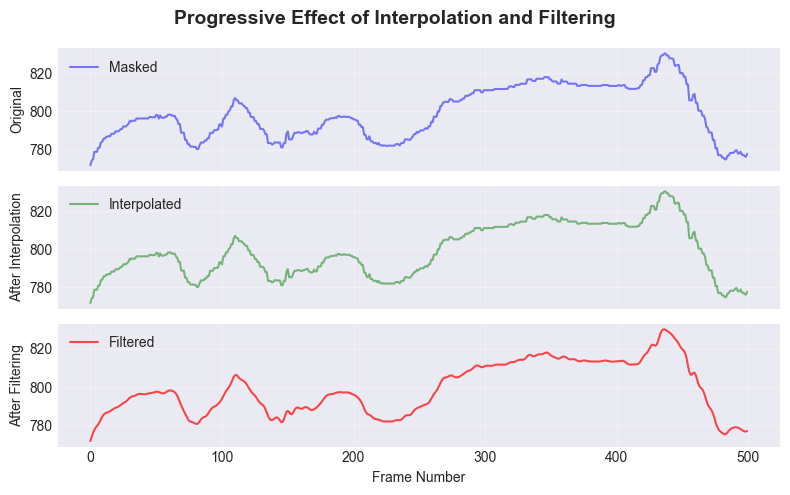

In [8]:
display('Step 4: Interpolate & Filter')

# Check if already processed
interp_dir = Path(CFG.OUT_BASE) / "interp_filtered"
exists, interp_files = check_files_exist("*_interp_filt.csv", interp_dir)
display_status("Interpolation & Filtering", exists, len(interp_files))

if not SCIPY_AVAILABLE:
    display('SciPy not available! Install scipy for filtering')

if not exists or OVERWRITE:
    if SCIPY_AVAILABLE:
        print("\nProcessing...")
        print(f"Settings:")
        print(f"  Max interpolation gap: {CFG.MAX_INTERP_RUN} frames ({CFG.MAX_INTERP_RUN/CFG.FPS:.1f}s)")
        print(f"  Butterworth filter: Order {CFG.FILTER_ORDER}, Cutoff {CFG.CUTOFF_HZ} Hz")
        
        # Process example
        if 'df_masked' in locals():
            df_processed = df_masked.copy()
            
            # Count NaN gaps before interpolation
            x37_col = next((c for c in df_processed.columns if c.lower() == 'x37'), None)
            if x37_col:
                nan_mask = pd.isna(df_processed[x37_col])
                gaps_before = nan_mask.sum()
            
            # Apply interpolation and filtering
            for col in df_processed.columns:
                if col.lower().startswith(('x', 'y')):
                    # Interpolate
                    df_processed[col] = interpolate_run_limited(df_processed[col], CFG.MAX_INTERP_RUN)
                    # Filter
                    df_processed[col] = butterworth_segment_filter(
                        df_processed[col], CFG.FILTER_ORDER, CFG.CUTOFF_HZ, CFG.FPS
                    )
            
            # Count NaN gaps after interpolation
            if x37_col:
                nan_mask_after = pd.isna(df_processed[x37_col])
                gaps_after = nan_mask_after.sum()
                print(f"\nInterpolation effect:")
                print(f"  NaN frames before: {gaps_before} ({gaps_before/len(df_processed)*100:.1f}%)")
                print(f"  NaN frames after: {gaps_after} ({gaps_after/len(df_processed)*100:.1f}%)")
                print(f"  Filled: {gaps_before - gaps_after} frames")
            
            # Save if requested
            if SAVE_INTERP_FILTERED:
                for fp in tqdm(files, desc="Processing all files"):
                    pid, _ = parse_participant_trial(fp.name)
                    cond = get_condition_for_file(fp.name, condition_map)
                    
                    # Load masked version
                    masked_path = masked_dir / get_output_filename(fp.name, pid, cond, "_masked")
                    if masked_path.exists():
                        df = pd.read_csv(masked_path)
                    else:
                        continue
                    
                    # Process
                    for col in df.columns:
                        if col.lower().startswith(('x', 'y')):
                            df[col] = interpolate_run_limited(df[col], CFG.MAX_INTERP_RUN)
                            df[col] = butterworth_segment_filter(
                                df[col], CFG.FILTER_ORDER, CFG.CUTOFF_HZ, CFG.FPS
                            )
                    
                    out_name = get_output_filename(fp.name, pid, cond, "_interp_filt")
                    out_path = interp_dir / out_name
                    
                    if OVERWRITE or not out_path.exists():
                        df.to_csv(out_path, index=False)
            
            # Visualize filtering effect
            print("\nEffect of interpolation and filtering:")
            fig, axes = plt.subplots(3, 1, figsize=(8, 5), sharex=True)
            
            frames = np.arange(500)  # Show first 500 frames
            if x37_col and len(df_masked) > 500:
                axes[0].plot(frames, df_masked[x37_col].iloc[:500], 'b-', alpha=0.5, label='Masked')
                axes[0].set_ylabel('Original')
                axes[0].legend()
                axes[0].grid(True, alpha=0.3)
                
                # Show interpolated only
                df_interp_only = df_masked.copy()
                df_interp_only[x37_col] = interpolate_run_limited(df_interp_only[x37_col], CFG.MAX_INTERP_RUN)
                axes[1].plot(frames, df_interp_only[x37_col].iloc[:500], 'g-', alpha=0.5, label='Interpolated')
                axes[1].set_ylabel('After Interpolation')
                axes[1].legend()
                axes[1].grid(True, alpha=0.3)
                
                axes[2].plot(frames, df_processed[x37_col].iloc[:500], 'r-', alpha=0.7, label='Filtered')
                axes[2].set_ylabel('After Filtering')
                axes[2].set_xlabel('Frame Number')
                axes[2].legend()
                axes[2].grid(True, alpha=0.3)
            
            plt.suptitle('Progressive Effect of Interpolation and Filtering', fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.show()
    
else:
    print("Loading existing filtered data for visualization...")
    df_processed = pd.read_csv(interp_files[0])
    plot_time_series(df_processed, landmark_idx=37, title=f"Filtered Data - {interp_files[0].name}")

## Step 5: Normalize to Screen Coordinates

Convert pixel coordinates to screen-relative coordinates [0,1] for resolution independence.

'Step 5: Normalize Coordinates'


Screen dimensions: 2560 × 1440 pixels

Processing...

Normalization effect:
  X coordinates:
    Before: [689.5, 994.0]
    After:  [0.269, 0.388]
  Y coordinates:
    Before: [432.2, 687.2]
    After:  [0.300, 0.477]


Normalizing all files:   0%|          | 0/143 [00:00<?, ?it/s]

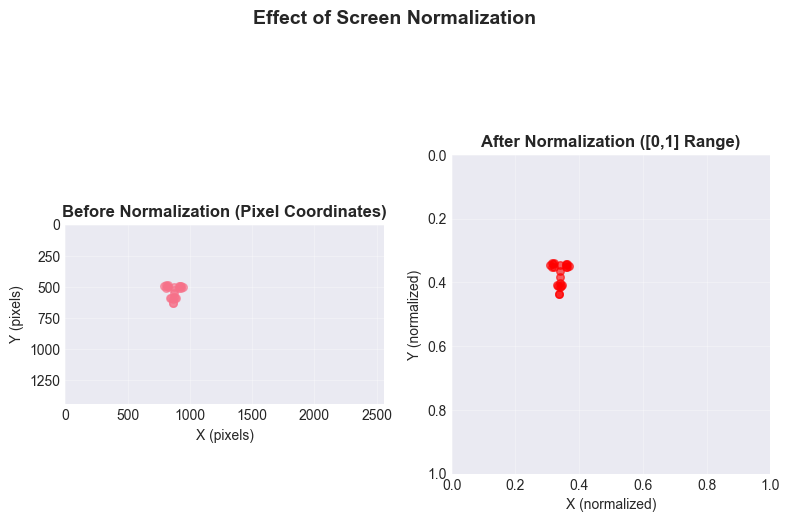


Steps 1-5 Complete! Data is now ready for feature extraction.


In [9]:
display('Step 5: Normalize Coordinates')

# Check if already processed
norm_dir = Path(CFG.OUT_BASE) / "norm_screen"
exists, norm_files = check_files_exist("*_norm.csv", norm_dir)
display_status("Screen normalization", exists, len(norm_files))

print(f"\nScreen dimensions: {CFG.IMG_WIDTH} × {CFG.IMG_HEIGHT} pixels")

if not exists or OVERWRITE:
    print("\nProcessing...")
    
    # Normalize example
    if 'df_processed' in locals():
        df_norm = normalize_to_screen(df_processed, CFG.IMG_WIDTH, CFG.IMG_HEIGHT)
        
        # Show before/after statistics
        x_cols = [c for c in df_norm.columns if c.lower().startswith('x')]
        y_cols = [c for c in df_norm.columns if c.lower().startswith('y')]
        
        print("\nNormalization effect:")
        print("  X coordinates:")
        if x_cols:
            before_range = (df_processed[x_cols].min().min(), df_processed[x_cols].max().max())
            after_range = (df_norm[x_cols].min().min(), df_norm[x_cols].max().max())
            print(f"    Before: [{before_range[0]:.1f}, {before_range[1]:.1f}]")
            print(f"    After:  [{after_range[0]:.3f}, {after_range[1]:.3f}]")
        
        print("  Y coordinates:")
        if y_cols:
            before_range = (df_processed[y_cols].min().min(), df_processed[y_cols].max().max())
            after_range = (df_norm[y_cols].min().min(), df_norm[y_cols].max().max())
            print(f"    Before: [{before_range[0]:.1f}, {before_range[1]:.1f}]")
            print(f"    After:  [{after_range[0]:.3f}, {after_range[1]:.3f}]")
        
        # Save if requested
        if SAVE_NORM:
            for fp in tqdm(files, desc="Normalizing all files"):
                pid, _ = parse_participant_trial(fp.name)
                cond = get_condition_for_file(fp.name, condition_map)
                
                # Load filtered version
                interp_path = interp_dir / get_output_filename(fp.name, pid, cond, "_interp_filt")
                if interp_path.exists():
                    df = pd.read_csv(interp_path)
                else:
                    continue
                
                df_n = normalize_to_screen(df, CFG.IMG_WIDTH, CFG.IMG_HEIGHT)
                
                out_name = get_output_filename(fp.name, pid, cond, "_norm")
                out_path = norm_dir / out_name
                
                if OVERWRITE or not out_path.exists():
                    df_n.to_csv(out_path, index=False)
        
        # Visualize normalized coordinates
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 6))
        
        # Before normalization
        sample_frame = 100
        if len(df_processed) > sample_frame:
            x_before = df_processed[x_cols].iloc[sample_frame].values
            y_before = df_processed[y_cols].iloc[sample_frame].values
            ax1.scatter(x_before, y_before, s=30, alpha=0.6)
            ax1.set_xlim(0, CFG.IMG_WIDTH)
            ax1.set_ylim(0, CFG.IMG_HEIGHT)
            ax1.invert_yaxis()
            ax1.set_aspect('equal')
            ax1.set_title('Before Normalization (Pixel Coordinates)', fontweight='bold')
            ax1.set_xlabel('X (pixels)')
            ax1.set_ylabel('Y (pixels)')
            ax1.grid(True, alpha=0.3)
        
        # After normalization
        if len(df_norm) > sample_frame:
            x_after = df_norm[x_cols].iloc[sample_frame].values
            y_after = df_norm[y_cols].iloc[sample_frame].values
            ax2.scatter(x_after, y_after, s=30, alpha=0.6, color='red')
            ax2.set_xlim(0, 1)
            ax2.set_ylim(0, 1)
            ax2.invert_yaxis()
            ax2.set_aspect('equal')
            ax2.set_title('After Normalization ([0,1] Range)', fontweight='bold')
            ax2.set_xlabel('X (normalized)')
            ax2.set_ylabel('Y (normalized)')
            ax2.grid(True, alpha=0.3)
        
        plt.suptitle('Effect of Screen Normalization', fontsize=14, fontweight='bold')
        plt.tight_layout()
        plt.show()
    
else:
    print("Loading existing normalized data for visualization...")
    df_norm = pd.read_csv(norm_files[0])
    plot_landmark_scatter(df_norm, title=f"Normalized Landmarks - {norm_files[0].name}", sample_frame=100)

print("\nSteps 1-5 Complete! Data is now ready for feature extraction.")

## Step 6: Build Templates

Create global and per-participant templates for Procrustes alignment.

'Step 6: Build Templates'

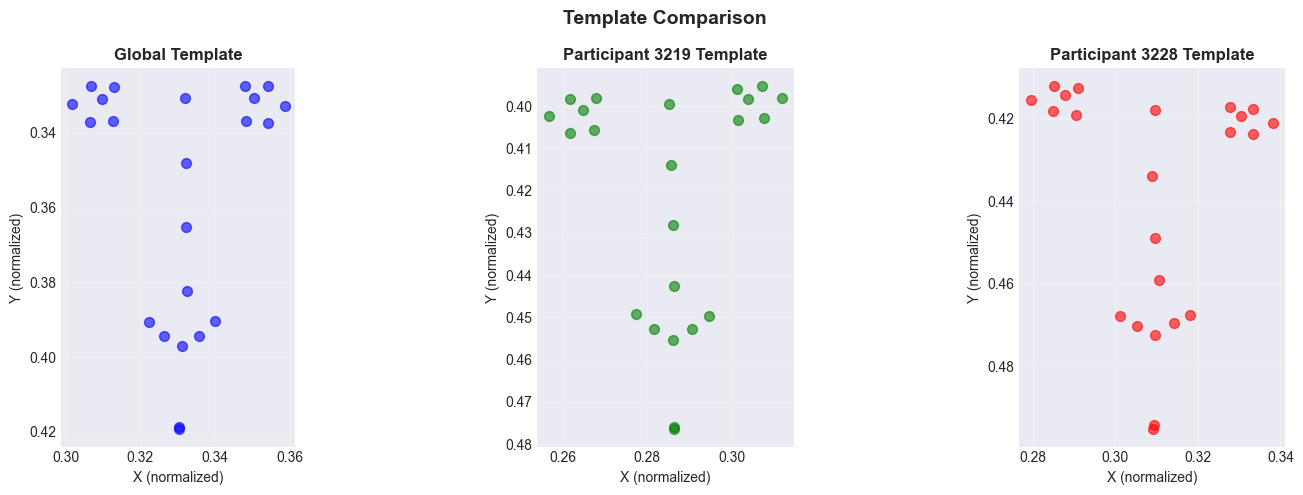


Templates show the average facial configuration for alignment.


In [10]:
display('Step 6: Build Templates')

# Check if templates exist
template_dir = Path(CFG.OUT_BASE) / "templates"
global_template_path = template_dir / "global_template.csv"
exists_global = global_template_path.exists()

# Count participant templates
participant_templates = list(template_dir.glob("participant_*_template.csv")) if template_dir.exists() else []

display_status("Template building", exists_global, len(participant_templates))

if not exists_global or OVERWRITE_TEMPLATES:
    print("\nBuilding templates...")
    
    # Group files by participant
    part_to_files = {}
    for fp in files:
        pid, _ = parse_participant_trial(fp.name)
        part_to_files.setdefault(pid, []).append(fp.name)
    
    print(f"Building templates for {len(part_to_files)} participants")
    
    # Function to compute template
    def compute_template_across_files(file_names):
        if not file_names:
            return pd.DataFrame()
        
        all_frames = []
        for fname in file_names:
            # Find corresponding normalized file
            for norm_file in norm_files:
                if fname.split('_')[0] in norm_file.name:  # Match participant ID
                    df = pd.read_csv(norm_file)
                    all_frames.append(df)
                    break
        
        if not all_frames:
            return pd.DataFrame()
        
        # Concatenate all frames
        big_df = pd.concat(all_frames, axis=0, ignore_index=True)
        
        # Get column names
        x_cols = [c for c in big_df.columns if c.lower().startswith('x')]
        y_cols = [c for c in big_df.columns if c.lower().startswith('y')]
        
        # Compute mean position for each landmark
        template = pd.DataFrame(index=[0], columns=x_cols + y_cols, dtype=float)
        template[x_cols] = big_df[x_cols].mean(axis=0, skipna=True).values
        template[y_cols] = big_df[y_cols].mean(axis=0, skipna=True).values
        
        return template
    
    # Build global template
    if RUN_TEMPLATES:
        all_file_names = [fp.name for fp in files]
        global_template = compute_template_across_files(all_file_names)
        
        if not global_template.empty:
            template_dir.mkdir(parents=True, exist_ok=True)
            global_template.to_csv(global_template_path, index=False)
            print("Global template created")
        
        # Build per-participant templates
        for pid, file_list in tqdm(part_to_files.items(), desc="Building participant templates"):
            template = compute_template_across_files(file_list)
            if not template.empty:
                part_path = template_dir / f"participant_{pid}_template.csv"
                template.to_csv(part_path, index=False)
        
        print(f"Built templates for {len(part_to_files)} participants")

# Visualize templates
if global_template_path.exists():
    global_template = pd.read_csv(global_template_path)
    
    # Plot global template
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Global template
    x_cols = [c for c in global_template.columns if c.lower().startswith('x')]
    y_cols = [c for c in global_template.columns if c.lower().startswith('y')]
    
    if x_cols and y_cols:
        x_vals = global_template[x_cols].values.flatten()
        y_vals = global_template[y_cols].values.flatten()
        
        axes[0].scatter(x_vals, y_vals, s=50, alpha=0.6, color='blue')
        axes[0].set_title('Global Template', fontweight='bold')
        axes[0].set_xlabel('X (normalized)')
        axes[0].set_ylabel('Y (normalized)')
        axes[0].invert_yaxis()
        axes[0].set_aspect('equal')
        axes[0].grid(True, alpha=0.3)
    
    # Load and plot first two participant templates for comparison
    if len(participant_templates) >= 2:
        for i, pt_file in enumerate(participant_templates[:2]):
            pt = pd.read_csv(pt_file)
            x_vals = pt[x_cols].values.flatten()
            y_vals = pt[y_cols].values.flatten()
            
            axes[i+1].scatter(x_vals, y_vals, s=50, alpha=0.6, color=['green', 'red'][i])
            pid = pt_file.stem.split('_')[1]  # Extract participant ID
            axes[i+1].set_title(f'Participant {pid} Template', fontweight='bold')
            axes[i+1].set_xlabel('X (normalized)')
            axes[i+1].set_ylabel('Y (normalized)')
            axes[i+1].invert_yaxis()
            axes[i+1].set_aspect('equal')
            axes[i+1].grid(True, alpha=0.3)
    
    plt.suptitle('Template Comparison', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\nTemplates show the average facial configuration for alignment.")

## Step 7: Extract Features

Compute behavioral metrics using three different normalization approaches.

' Step 7: Extract Features'

Three feature extraction routes:
1. Procrustes Global - Align to population average
2. Procrustes Participant - Align to individual baseline
3. Original - Raw normalized coordinates

Feature extraction status:
  Yes procrustes_global
  Yes procrustes_participant
  Yes original

Using sample file: Participant 3220, Condition M

Extracting Original features...
Features extracted:
  • head_rotation_rad: 30598 frames
  • blink_aperture: 30598 frames
  • mouth_aperture: 30598 frames
  • pupil_dx: 30598 frames
  • pupil_dy: 30598 frames
  • pupil_metric: 30598 frames
  • center_face_magnitude: 30598 frames
  • center_face_x: 30598 frames
  • center_face_y: 30598 frames

Extracting Procrustes Global features...
Additional Procrustes features:
  • head_tx: 30598 frames
  • head_ty: 30598 frames
  • head_scale: 30598 frames
  • head_motion_mag: 30598 frames


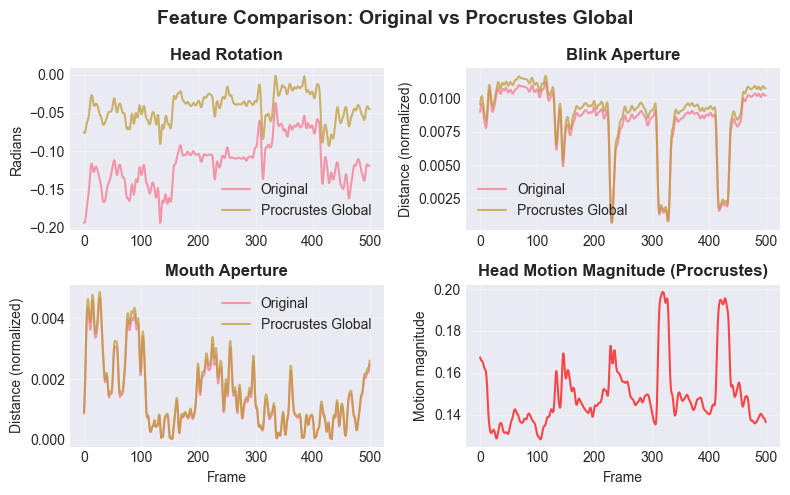


Note: Procrustes features remove individual geometry differences,
    focusing on relative movements and deviations from templates.

Comparing feature distributions across normalization routes...


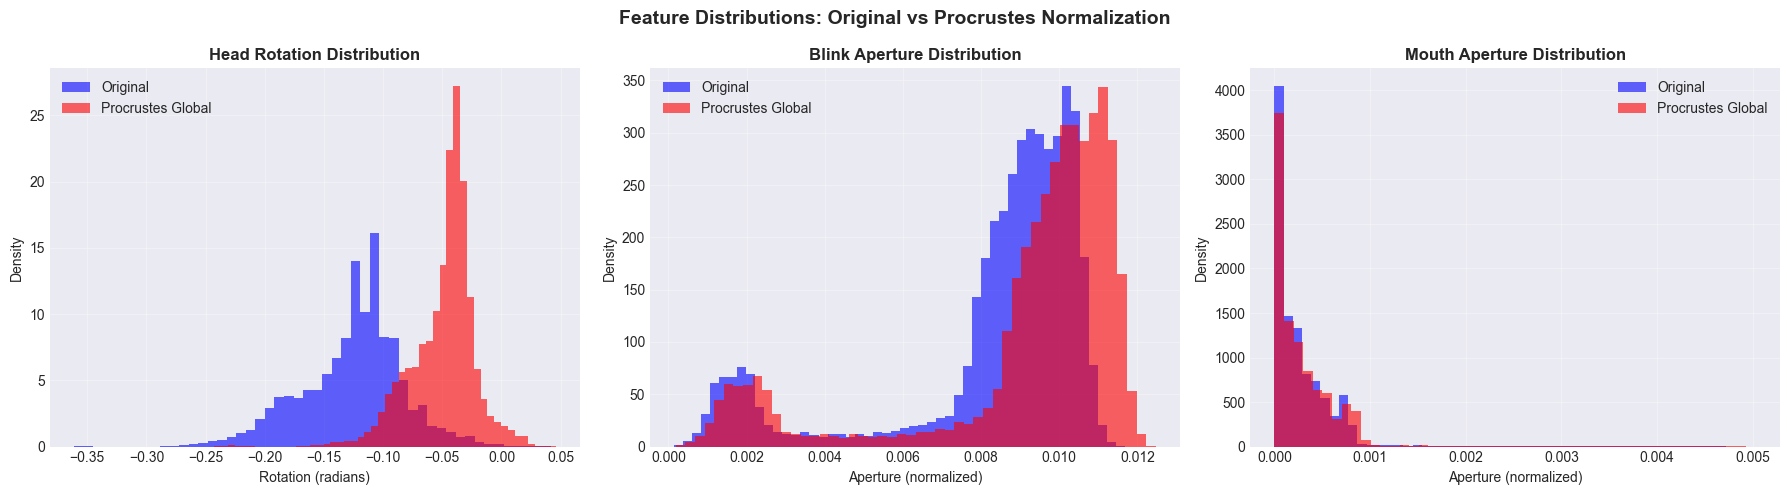


Statistical Comparison:

  Head Rotation Rad:
    Original:  Mean=-0.1255, Std=0.0432
    Procrustes: Mean=-0.0489, Std=0.0271
    Difference: 0.0766

  Blink Aperture:
    Original:  Mean=0.0083, Std=0.0026
    Procrustes: Mean=0.0091, Std=0.0028
    Difference: 0.0008

  Mouth Aperture:
    Original:  Mean=0.0003, Std=0.0004
    Procrustes: Mean=0.0003, Std=0.0004
    Difference: 0.0000

Feature Correlations between Original and Procrustes:
  • Head Rotation Rad: r = 0.933
  • Blink Aperture: r = 0.998
  • Mouth Aperture: r = 0.999

Procrustes-Specific Features:


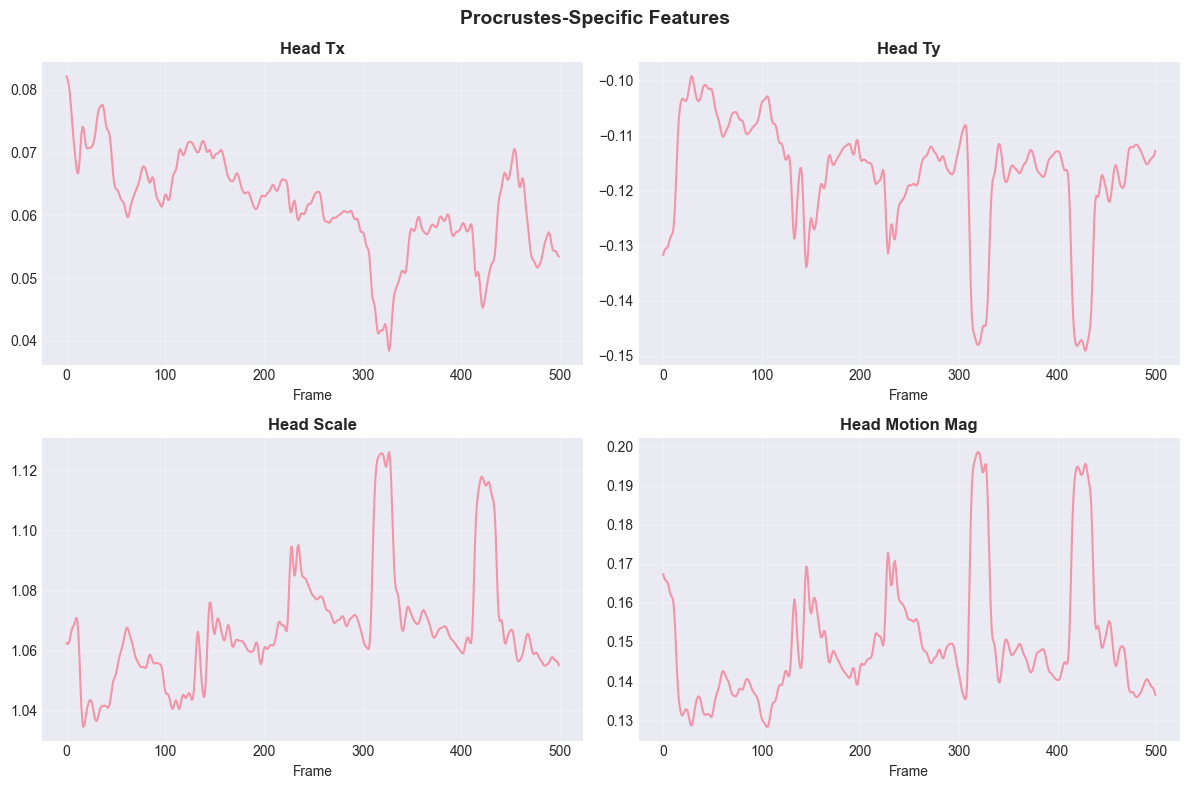

In [11]:
display(' Step 7: Extract Features')

print("Three feature extraction routes:")
print("1. Procrustes Global - Align to population average")
print("2. Procrustes Participant - Align to individual baseline")
print("3. Original - Raw normalized coordinates")

# Check what features already exist
feat_dir = Path(CFG.OUT_BASE) / "features"
routes_status = {
    "procrustes_global": (feat_dir / "procrustes_global.csv").exists() if feat_dir.exists() else False,
    "procrustes_participant": (feat_dir / "procrustes_participant.csv").exists() if feat_dir.exists() else False,
    "original": (feat_dir / "original.csv").exists() if feat_dir.exists() else False
}

print("\nFeature extraction status:")
for route, exists in routes_status.items():
    status = "Yes" if exists else "Processing needed"
    print(f"  {status} {route}")

# Load sample normalized file for demonstration
if norm_files:
    sample_norm = pd.read_csv(norm_files[0])
    sample_name = norm_files[0].stem.split('_')
    sample_pid = sample_name[0]
    sample_cond = sample_name[1] if len(sample_name) > 1 else 'unknown'
    
    print(f"\nUsing sample file: Participant {sample_pid}, Condition {sample_cond}")
    
    # Extract features for visualization
    rel_idxs = relevant_indices()
    
    # Original features
    if RUN_FEATURES_ORIGINAL:
        print("\nExtracting Original features...")
        original_feats = original_features_for_file(sample_norm)
        
        print("Features extracted:")
        for feat_name, values in original_feats.items():
            print(f"  • {feat_name}: {len(values)} frames")
    
    # Procrustes Global features
    if RUN_FEATURES_PROCRUSTES_GLOBAL and global_template_path.exists():
        print("\nExtracting Procrustes Global features...")
        global_template = pd.read_csv(global_template_path)
        proc_global_feats = procrustes_features_for_file(sample_norm, global_template, rel_idxs)
        
        print("Additional Procrustes features:")
        for feat in ['head_tx', 'head_ty', 'head_scale', 'head_motion_mag']:
            if feat in proc_global_feats:
                print(f"  • {feat}: {len(proc_global_feats[feat])} frames")
    
    # Visualize feature comparison
    fig, axes = plt.subplots(2, 2, figsize=(8, 5))
    
    frames = np.arange(min(500, len(sample_norm)))  # First 500 frames
    
    # Plot different features
    if 'original_feats' in locals():
        # Head rotation
        if 'head_rotation_rad' in original_feats:
            axes[0,0].plot(frames, original_feats['head_rotation_rad'][:500], 
                          label='Original', alpha=0.7)
        if 'proc_global_feats' in locals() and 'head_rotation_rad' in proc_global_feats:
            axes[0,0].plot(frames, proc_global_feats['head_rotation_rad'][:500], 
                          label='Procrustes Global', alpha=0.7)
        axes[0,0].set_title('Head Rotation', fontweight='bold')
        axes[0,0].set_ylabel('Radians')
        axes[0,0].legend()
        axes[0,0].grid(True, alpha=0.3)
        
        # Blink aperture
        if 'blink_aperture' in original_feats:
            axes[0,1].plot(frames, original_feats['blink_aperture'][:500], 
                          label='Original', alpha=0.7)
        if 'proc_global_feats' in locals() and 'blink_aperture' in proc_global_feats:
            axes[0,1].plot(frames, proc_global_feats['blink_aperture'][:500], 
                          label='Procrustes Global', alpha=0.7)
        axes[0,1].set_title('Blink Aperture', fontweight='bold')
        axes[0,1].set_ylabel('Distance (normalized)')
        axes[0,1].legend()
        axes[0,1].grid(True, alpha=0.3)
        
        # Mouth aperture
        if 'mouth_aperture' in original_feats:
            axes[1,0].plot(frames, original_feats['mouth_aperture'][:500], 
                          label='Original', alpha=0.7)
        if 'proc_global_feats' in locals() and 'mouth_aperture' in proc_global_feats:
            axes[1,0].plot(frames, proc_global_feats['mouth_aperture'][:500], 
                          label='Procrustes Global', alpha=0.7)
        axes[1,0].set_title('Mouth Aperture', fontweight='bold')
        axes[1,0].set_xlabel('Frame')
        axes[1,0].set_ylabel('Distance (normalized)')
        axes[1,0].legend()
        axes[1,0].grid(True, alpha=0.3)
        
        # Head motion (Procrustes only)
        if 'proc_global_feats' in locals() and 'head_motion_mag' in proc_global_feats:
            axes[1,1].plot(frames, proc_global_feats['head_motion_mag'][:500], 
                          color='red', alpha=0.7)
            axes[1,1].set_title('Head Motion Magnitude (Procrustes)', fontweight='bold')
        axes[1,1].set_xlabel('Frame')
        axes[1,1].set_ylabel('Motion magnitude')
        axes[1,1].grid(True, alpha=0.3)
    
    plt.suptitle('Feature Comparison: Original vs Procrustes Global', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print("\nNote: Procrustes features remove individual geometry differences,")
    print("    focusing on relative movements and deviations from templates.")

    # Compare feature distributions across normalization routes
    print("\nComparing feature distributions across normalization routes...")

    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    # Head rotation comparison
    if 'original_feats' in locals() and 'head_rotation_rad' in original_feats:
        axes[0].hist(original_feats['head_rotation_rad'], bins=50, alpha=0.6,
                    label='Original', density=True, color='blue')
    if 'proc_global_feats' in locals() and 'head_rotation_rad' in proc_global_feats:
        axes[0].hist(proc_global_feats['head_rotation_rad'], bins=50, alpha=0.6,
                    label='Procrustes Global', density=True, color='red')
    axes[0].set_title('Head Rotation Distribution', fontweight='bold')
    axes[0].set_xlabel('Rotation (radians)')
    axes[0].set_ylabel('Density')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Blink aperture comparison
    if 'original_feats' in locals() and 'blink_aperture' in original_feats:
        axes[1].hist(original_feats['blink_aperture'], bins=50, alpha=0.6,
                    label='Original', density=True, color='blue')
    if 'proc_global_feats' in locals() and 'blink_aperture' in proc_global_feats:
        axes[1].hist(proc_global_feats['blink_aperture'], bins=50, alpha=0.6,
                    label='Procrustes Global', density=True, color='red')
    axes[1].set_title('Blink Aperture Distribution', fontweight='bold')
    axes[1].set_xlabel('Aperture (normalized)')
    axes[1].set_ylabel('Density')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)

    # Mouth aperture comparison
    if 'original_feats' in locals() and 'mouth_aperture' in original_feats:
        axes[2].hist(original_feats['mouth_aperture'], bins=50, alpha=0.6,
                    label='Original', density=True, color='blue')
    if 'proc_global_feats' in locals() and 'mouth_aperture' in proc_global_feats:
        axes[2].hist(proc_global_feats['mouth_aperture'], bins=50, alpha=0.6,
                    label='Procrustes Global', density=True, color='red')
    axes[2].set_title('Mouth Aperture Distribution', fontweight='bold')
    axes[2].set_xlabel('Aperture (normalized)')
    axes[2].set_ylabel('Density')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)

    plt.suptitle('Feature Distributions: Original vs Procrustes Normalization',
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Statistical comparison
    print("\nStatistical Comparison:")
    features_to_compare = ['head_rotation_rad', 'blink_aperture', 'mouth_aperture']

    for feat in features_to_compare:
        if feat in original_feats and feat in proc_global_feats:
            orig_vals = np.array(original_feats[feat])
            proc_vals = np.array(proc_global_feats[feat])

            # Remove NaN values for comparison
            orig_clean = orig_vals[~np.isnan(orig_vals)]
            proc_clean = proc_vals[~np.isnan(proc_vals)]

            print(f"\n  {feat.replace('_', ' ').title()}:")
            print(f"    Original:  Mean={np.mean(orig_clean):.4f}, Std={np.std(orig_clean):.4f}")
            print(f"    Procrustes: Mean={np.mean(proc_clean):.4f}, Std={np.std(proc_clean):.4f}")
            print(f"    Difference: {abs(np.mean(orig_clean) - np.mean(proc_clean)):.4f}")

    # Feature correlation analysis
    if 'original_feats' in locals() and 'proc_global_feats' in locals():
        print("\nFeature Correlations between Original and Procrustes:")
        
        for feat in features_to_compare:
            if feat in original_feats and feat in proc_global_feats:
                orig_vals = np.array(original_feats[feat])
                proc_vals = np.array(proc_global_feats[feat])
                
                # Remove NaN for correlation
                mask = ~(np.isnan(orig_vals) | np.isnan(proc_vals))
                if mask.sum() > 10:  # Need enough data points
                    corr = np.corrcoef(orig_vals[mask], proc_vals[mask])[0, 1]
                    print(f"  • {feat.replace('_', ' ').title()}: r = {corr:.3f}")

    # Procrustes-specific features visualization
    if 'proc_global_feats' in locals():
        print("\nProcrustes-Specific Features:")
        
        proc_specific = ['head_tx', 'head_ty', 'head_scale', 'head_motion_mag']
        available_proc = [f for f in proc_specific if f in proc_global_feats]
        
        if available_proc:
            fig, axes = plt.subplots(2, 2, figsize=(12, 8))
            axes = axes.flatten()
            
            for i, feat in enumerate(available_proc[:4]):
                if i < len(axes):
                    axes[i].plot(frames, proc_global_feats[feat][:500], alpha=0.7)
                    axes[i].set_title(feat.replace('_', ' ').title(), fontweight='bold')
                    axes[i].set_xlabel('Frame')
                    axes[i].grid(True, alpha=0.3)
            
            # Hide unused subplots
            for i in range(len(available_proc), len(axes)):
                axes[i].set_visible(False)
            
            plt.suptitle('Procrustes-Specific Features', fontsize=14, fontweight='bold')
            plt.tight_layout()
            plt.show()

## Step 8: Compute Linear Metrics

Calculate velocity, acceleration, and RMS for each feature.

In [12]:
display('Step 8: Linear Metrics')

print("Linear metrics compute motion characteristics:")
print("  • Mean Velocity - How fast features change")
print("  • Mean Acceleration - Rate of velocity change")
print("  • RMS - Overall variability")

# Check existing linear metrics
lm_dir = Path(CFG.OUT_BASE) / "linear_metrics"
linear_status = {
    "procrustes_global": (lm_dir / "procrustes_global_linear.csv").exists() if lm_dir.exists() else False,
    "procrustes_participant": (lm_dir / "procrustes_participant_linear.csv").exists() if lm_dir.exists() else False,
    "original": (lm_dir / "original_linear.csv").exists() if lm_dir.exists() else False
}

print("\nLinear metrics status:")
for route, exists in linear_status.items():
    status = "Complete" if exists else "⏳ Processing needed"
    print(f"  {status} {route}")

# If linear metrics exist, load and visualize
if any(linear_status.values()):
    for route, exists in linear_status.items():
        if exists:
            linear_file = lm_dir / f"{route}_linear.csv"
            df_linear = pd.read_csv(linear_file)
            
            print(f"\n{route.replace('_', ' ').title()} Linear Metrics:")
            print(f"  Shape: {df_linear.shape}")
            print(f"  Participants: {df_linear['participant'].nunique()}")
            print(f"  Conditions: {df_linear['condition'].unique()}")
            
            # Get RMS columns (features ending with '_rms')
            rms_cols = [col for col in df_linear.columns if col.endswith('_rms')]
            
            if rms_cols:
                print(f"\nAvailable RMS metrics ({len(rms_cols)}):")
                # Show sample RMS values
                sample_rms = df_linear[rms_cols].mean()
                for col, value in sample_rms.items():
                    metric_name = col.replace('_rms', '').replace('_', ' ')
                    print(f"    • {metric_name}: {value:.4f}")
            
            break  # Show analysis for first available route only

else:
    print("\nNo linear metrics found. Run Step 8 in the pipeline to generate them.")

'Step 8: Linear Metrics'

Linear metrics compute motion characteristics:
  • Mean Velocity - How fast features change
  • Mean Acceleration - Rate of velocity change
  • RMS - Overall variability

Linear metrics status:
  Complete procrustes_global
  Complete procrustes_participant
  Complete original

Procrustes Global Linear Metrics:
  Shape: (4670, 36)
  Participants: 48
  Conditions: ['H' 'L' 'M']

Available RMS metrics (10):
    • head rotation rad: 0.0378
    • head tx: 0.3213
    • head ty: 0.3845
    • head scale: 0.0283
    • head motion mag: 0.5631
    • blink aperture: 0.0435
    • mouth aperture: 0.0121
    • pupil dx: 0.0053
    • pupil dy: 0.0134
    • pupil metric: 0.0079


## Dynamic Feature Visualization
- User sets whihc normlaizatiopn to use (original, global or participant level procrustes)
- Picks one normalized file automatically (pick_norm_file) and slices the first N seconds (default 60s) for visualization.
- Computes simple per-frame features directly in the notebook for quick visual checks:
- head_rotation_angle estimated from eye-corner vector,
- blink_dist computed as average vertical eyelid gap (left + right),
- mouth_dist Euclidean distance between mouth landmarks (63/67).
- Launches an interactive time-series viewer (create_interactive_pose_timeseries_viewer) that shows landmark trajectories and the feature traces together — ideal for quickly validating pipeline preprocessing and detecting failures (e.g., large jumps, bad interpolation).

Inputs:
- A normalized CSV selected by pick_norm_file from OUT_BASE/norm_screen.

Outputs:
- An interactive Matplotlib widget (shown inline) that overlays landmarks + feature plots.

Visualizing features from method: original
Selected file: 3101_H_norm.csv
Loaded 3600 frames (60.0 seconds) from 3101_H_norm.csv
Features computed:
  head_rotation_angle: 3600/3600 valid frames (100.0%)
  blink_dist: 3600/3600 valid frames (100.0%)
  mouth_dist: 3600/3600 valid frames (100.0%)

Launching interactive viewer...
Controls:
  - Use slider to navigate frames manually
  - Click 'Play' to auto-advance through frames
  - View shows 60-second window around current frame


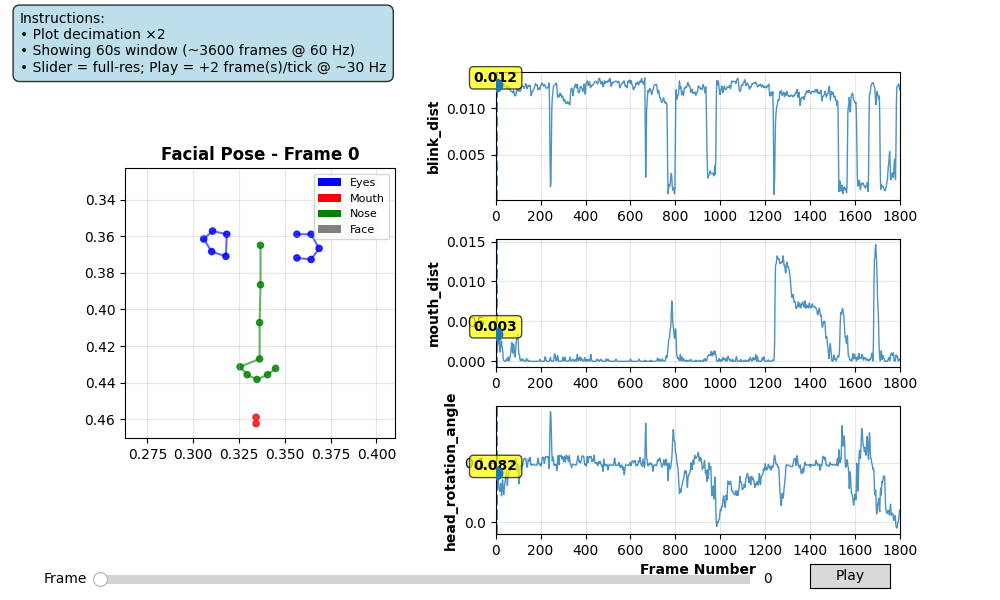

In [8]:
# Try to use widget backend, fall back to inline if not available
try:
    %matplotlib widget
    backend = "widget"
except RuntimeError:
    %matplotlib inline
    backend = "inline"
    print("Note: Interactive widget backend not available. Using static inline display.")
    print("To enable interactive plots, install: pip install ipympl")

import numpy as np
import pandas as pd
from utils.config import CFG
from utils.nb_utils import pick_norm_file, slice_first_seconds, series_num
from utils.viz_utils import create_interactive_pose_timeseries_viewer
from pathlib import Path

# Pick the normalization method to visualize
method = "original"  # options: "original", "procrustes_global", "procrustes_participant"
print(f"Visualizing features from method: {method}")

# Pick a normalized file (uses OUT_BASE/norm_screen)
try:
    norm_path = pick_norm_file(CFG.OUT_BASE)
    print(f"Selected file: {norm_path.name}")
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please ensure the pipeline has been run through Step 5 (normalization)")
    raise
    
# Load and trim to first 60s (or fewer if shorter)
df_pose = slice_first_seconds(pd.read_csv(norm_path), CFG.FPS, 60)

n = len(df_pose)
if n < 2:
    raise ValueError(f"Normalized file {norm_path.name} is too short ({n} frames) to display.")

print(f"Loaded {n} frames ({n/CFG.FPS:.1f} seconds) from {norm_path.name}")

# Compute simple features directly from normalized coordinates
# Head rotation (eye corner vector, same indices as pipeline)
dx = (series_num(df_pose, "x", 46, n) - series_num(df_pose, "x", 37, n)).to_numpy(float)
dy = (series_num(df_pose, "y", 46, n) - series_num(df_pose, "y", 37, n)).to_numpy(float)
head_rotation_angle = np.arctan2(dy, dx)

# Blink: average vertical eyelid gap L/R (indices consistent with OpenPose 68)
Ltop = (series_num(df_pose, "y", 38, n) + series_num(df_pose, "y", 39, n)) / 2.0
Lbot = (series_num(df_pose, "y", 41, n) + series_num(df_pose, "y", 42, n)) / 2.0
Rtop = (series_num(df_pose, "y", 44, n) + series_num(df_pose, "y", 45, n)) / 2.0
Rbot = (series_num(df_pose, "y", 47, n) + series_num(df_pose, "y", 48, n)) / 2.0

blink_L = (Ltop - Lbot).abs().to_numpy(float)
blink_R = (Rtop - Rbot).abs().to_numpy(float)
blink_dist = np.where(
    np.isfinite(blink_L) & np.isfinite(blink_R),
    (blink_L + blink_R) / 2.0,
    np.where(np.isfinite(blink_L), blink_L,
             np.where(np.isfinite(blink_R), blink_R, np.nan))
)

# Mouth opening (63,67)
x63 = series_num(df_pose, "x", 63, n).to_numpy(float)
y63 = series_num(df_pose, "y", 63, n).to_numpy(float)
x67 = series_num(df_pose, "x", 67, n).to_numpy(float)
y67 = series_num(df_pose, "y", 67, n).to_numpy(float)
mouth_dist = np.sqrt((x67 - x63) ** 2 + (y67 - y63) ** 2)

# Assemble feature DataFrame (one row per frame)
df_feats = pd.DataFrame({
    "head_rotation_angle": head_rotation_angle,
    "blink_dist": blink_dist,
    "mouth_dist": mouth_dist,
})

print("Features computed:")
for feat in df_feats.columns:
    valid_count = (~np.isnan(df_feats[feat])).sum()
    print(f"  {feat}: {valid_count}/{n} valid frames ({valid_count/n*100:.1f}%)")

if backend == "widget":
    # Launch the interactive viewer with HALF SIZE (8x5 instead of 16x10)
    print(f"\nLaunching interactive viewer...")
    print("Controls:")
    print("  - Use slider to navigate frames manually")
    print("  - Click 'Play' to auto-advance through frames")
    print("  - View shows 60-second window around current frame")

    fig = create_interactive_pose_timeseries_viewer(
        df_raw=df_pose,
        df_features=df_feats,
        features_to_plot=["blink_dist", "mouth_dist", "head_rotation_angle"],
        pose_sampling_hz=CFG.FPS,
        plot_downsample=2,
        window_seconds=60,
        figsize=(10, 6)  # Half the original size (was 16, 10)
    )
else:
    # Fallback to static plots if widget backend not available (also half size)
    print("\nGenerating static plots (install ipympl for interactive viewer)...")
    
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(4, 1, figsize=(10, 6), sharex=True)
    
    # Time axis
    time_seconds = np.arange(n) / CFG.FPS
    
    # Plot each feature
    features = ["blink_dist", "mouth_dist", "head_rotation_angle"]
    for i, feat in enumerate(features):
        axes[i].plot(time_seconds, df_feats[feat], linewidth=1, alpha=0.8)
        axes[i].set_ylabel(feat.replace('_', ' ').title(), fontsize=6)  # Smaller font
        axes[i].grid(True, alpha=0.3)
        axes[i].tick_params(labelsize=7)  # Smaller tick labels
        
        # Highlight NaN regions
        nan_mask = np.isnan(df_feats[feat])
        if nan_mask.any():
            axes[i].fill_between(time_seconds, axes[i].get_ylim()[0], axes[i].get_ylim()[1],
                                where=nan_mask, alpha=0.2, color='red', label='Missing data')
    
    # Plot landmarks sample at specific frame
    sample_frame = min(100, n-1)
    ax_pose = axes[3]
    
    # Extract landmark positions
    x_cols = [c for c in df_pose.columns if c.lower().startswith('x')]
    y_cols = [c for c in df_pose.columns if c.lower().startswith('y')]
    
    if x_cols and y_cols:
        x_vals = df_pose[x_cols].iloc[sample_frame].values
        y_vals = df_pose[y_cols].iloc[sample_frame].values
        
        # Create scatter plot
        ax_pose.scatter(x_vals, y_vals, s=10, alpha=0.6)  # Smaller points
        ax_pose.set_ylabel('Y Position', fontsize=8)
        ax_pose.set_xlabel('X Position', fontsize=8)
        ax_pose.set_title(f'Facial Landmarks at t={sample_frame/CFG.FPS:.1f}s', fontsize=9)
        ax_pose.invert_yaxis()
        ax_pose.set_aspect('equal')
        ax_pose.grid(True, alpha=0.3)
        ax_pose.tick_params(labelsize=7)
    
    axes[-1].set_xlabel('Time (seconds)', fontsize=8)
    plt.suptitle(f'Pose Features from {norm_path.name}', fontsize=11, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    print(f"\nShowing first {n/CFG.FPS:.1f} seconds of data")
    print("Features displayed: blink distance, mouth distance, head rotation angle")